# Trajectory Dataset

In this project, we will be training a recurrent JEPA model to learn the trajectory. The trajector is provided by the following dataset.

## Environment
The setup consits of three parts: Walls, Agent and Actions.
- `Agent`: It is the point/region in space that moves in the space in a particular trajectory.
- `Walls`: These are confinement borders in the space. The agent cannot pass through the walls.
- `Action`: It gives us delta x and delta y from previous locations.

## Dataset Format.
We have two files: `states.npy` and `actions.npy`. They both are np array, which describes the environment and agent.
`states`: It has the shape (num_traj, traj_length, 2, 65, 65). It has two channels. 
- Channel 1: (i, n, 1, 65, 65) that describes the agent.
- Channel 2: (i, n, 0, 65, 65) that describes the borders and walls. 
`actions`: It has the shape (num_traj, traj_length-1, 2)

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
states = np.load("states.npy", mmap_mode="r")
actions = np.load("actions.npy", mmap_mode="r")

print(f"shape of states: {states.shape}")
print(f"shape of actions: {actions.shape}")

shape of states: (15000, 17, 2, 65, 65)
shape of actions: (15000, 16, 2)


## Visualizing trajectory.
Let us visualize the first trajectory. The all the visulaization in dark mode is native one. If you want light mode it will have some processing done. We will be using dark mode.

`TODO` : We have to confirm if the borders or walls do not move with time.

### How are we visualizing it.
There are three aspects to it. Enviromenment, Agent positions and Trajectory from actions.

- First, we will initialize all the data points of image to environment values i.e states[id][0][1].
- Second, we will modifying data points with agent position and color it `red` for all the trajectory points (i.e states[id][trj_id][id])
- Third, we will do two things. First: will compute exact position of agent (from image, by compuitng pixel location with highest value), this will form agent trajectory path (`blue` color). Second: will follow the pixel from initial agent position and adding delta_x and delta_y from actions, this will form action trajectory path (`red` color).

There are differences in agent trajectory and action trajectory (as pixel index is integer, but delta is in float), But they more or less point to the same location.

The function to use is `visualize_data_point`. It takes in three arguments:
- `index`: Integer, the visualize the state[index] dataset.
- `light_mode`: Boolean, if you want light mode give `True`.
- `mode`: Integer [0, 1, 2, 3, 4]. 0 just draws the environment and agent positions, mode 1 draws agent movement as pixels, mode 2 draws agent trajectory, mode 3 draws action trajectory and mode 4 draws everything.

In [292]:
# helper functions
# draws the borders on the image
def draw_borders(rgb_image, env, is_white_mode = False):
    if is_white_mode == True:
        rgb_image = np.ones(rgb_image.shape)
        rgb_image[:, :, 0] -= env 
        rgb_image[:, :, 1] -= env 
        rgb_image[:, :, 2] -= env
    else:
        rgb_image = np.zeros(rgb_image.shape)
        rgb_image[:, :, 0] = env 
        rgb_image[:, :, 1] = env 
        rgb_image[:, :, 2] = env
    return rgb_image

# function that finds the position of agent (max pixel value)
def find_agent_position(agent):
    max_index = (-1, -1)
    max_value = 0.0
    for i in range(65):
        for j in range(65):
            if agent[i][j] > max_value:
                max_value = agent[i][j]
                max_index = (i, j)
    return max_index

# draws the agent on the image
def draw_agent(rgb_image, agent, is_white_mode = False):
    if is_white_mode:
        rgb_image[:, :, 0] -= agent
    else:
        rgb_image[:, :, 0] += agent 

    return rgb_image

# draws the image
def draw_image(rgb_image):
    rgb_image = np.clip(rgb_image, 0, 1)
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

In [293]:
# Draws the image with trajectories and action
# Assuming the borders do not change with time
# There are three modes
# mode 0 - draws just the image
# mode 1 - draws image with agent trajectory (i.e based on states.npy)
# mode 2 - draws image with action trajectory (i.e baed on actions.npy)
# mode 3 - does (both mode 1 and mode 2)
def draw_traj_image(rgb_image, agent_traj, action_traj, light_mode = False, mode = 0):
    rgb_image = np.clip(rgb_image, 0, 1)
    plt.imshow(rgb_image)
    if mode == 2 or mode == 4:
        plt.plot(agent_traj[:, 1], agent_traj[:, 0], color='blue', linewidth=1)
        plt.scatter(agent_traj[:, 1], agent_traj[:, 0], color='blue', s=5, zorder=5)

    if mode == 3 or mode == 4:
        plt.plot(action_traj[:, 1], action_traj[:, 0], color='green', linewidth=1)
        plt.scatter(action_traj[:, 1], action_traj[:, 0], color='green', s=5, zorder=5)

    if mode > 0:
        color = 'red' if light_mode else 'yellow'
        plt.text(agent_traj[0][1], agent_traj[0][0], 'S', fontsize=6, color=color)
        plt.text(agent_traj[-1][1], agent_traj[-1][0], 'D', fontsize=6, color=color)
    plt.axis('off')
    plt.show()

In [294]:

def visualize_data_point(index = 0, light_mode = False, mode = 0):
    rgb_image = np.empty((65, 65, 3))
    rgb_image = draw_borders(rgb_image, states[index][0][1], light_mode)

    length = states[index].shape[0]
    agent_trajectory = np.zeros((length, 2))
    action_trajectory = np.zeros((length, 2))

    curr_pos = find_agent_position(states[index][0][0])
    agent_trajectory[0][0], agent_trajectory[0][1] = curr_pos[0], curr_pos[1]
    action_trajectory[0][0], action_trajectory[0][1] = curr_pos[0], curr_pos[1]

    for i in range(length):
        if i == 0 or mode == 1 or mode == 4:
            rgb_image = draw_agent(rgb_image, states[index][i][0], light_mode)
        if i > 0:
            curr_pos = find_agent_position(states[index][i][0])
            agent_trajectory[i][0], agent_trajectory[i][1] = curr_pos[0], curr_pos[1]
            action_trajectory[i][0] = action_trajectory[i-1][0] + actions[index][i-1][1]
            action_trajectory[i][1] = action_trajectory[i-1][1] + actions[index][i-1][0]

    print(f"final_position: {curr_pos}")
    print(f"action position: {action_trajectory[length-1]}")

    draw_traj_image(rgb_image, agent_trajectory, action_trajectory, light_mode, mode)


Given below is the visualization of the first data point and its trajectories.
Next will we randomly samply, 5 data points and visualize it using mode 4.

final_position: (20, 26)
action position: [19.77844795 26.05357924]


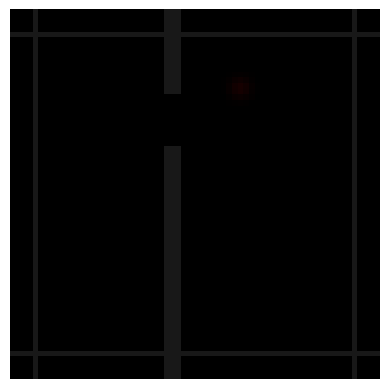

final_position: (20, 26)
action position: [19.77844795 26.05357924]


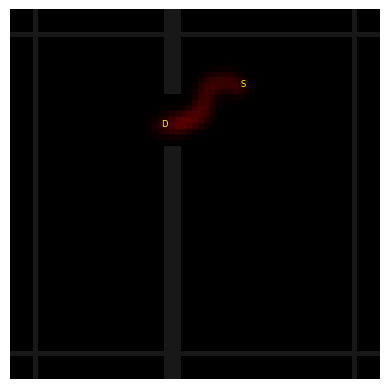

final_position: (20, 26)
action position: [19.77844795 26.05357924]


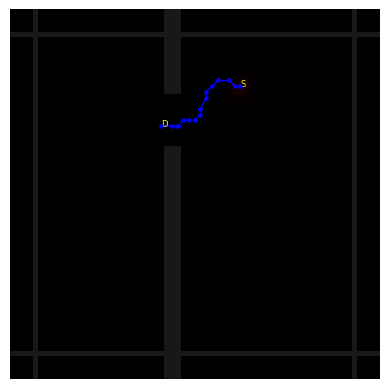

final_position: (20, 26)
action position: [19.77844795 26.05357924]


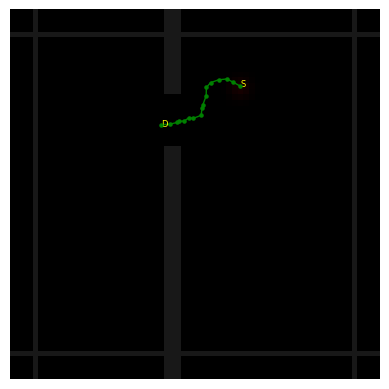

final_position: (20, 26)
action position: [19.77844795 26.05357924]


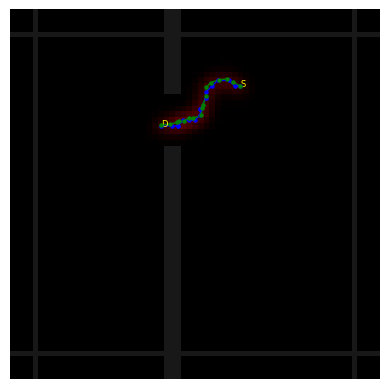

final_position: (20, 26)
action position: [19.77844795 26.05357924]


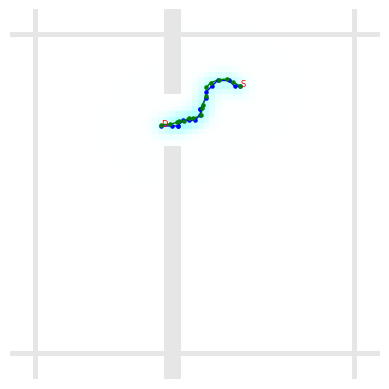

In [295]:
visualize_data_point(0, False, 0)
visualize_data_point(0, False, 1)
visualize_data_point(0, False, 2)
visualize_data_point(0, False, 3)
visualize_data_point(0, False, 4)
visualize_data_point(0, True, 4)

final_position: (29, 9)
action position: [29.42932115  8.94496699]


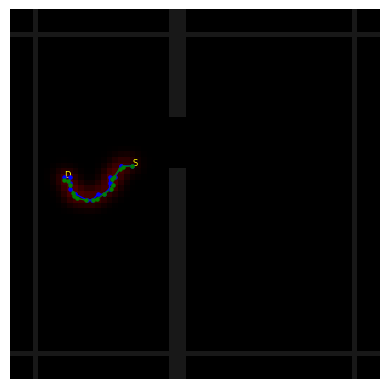

final_position: (43, 7)
action position: [39.6377429   3.86433353]


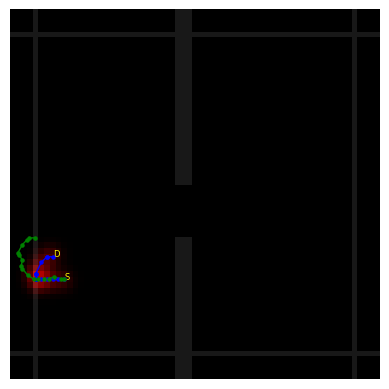

final_position: (20, 11)
action position: [20.60207945 10.38176517]


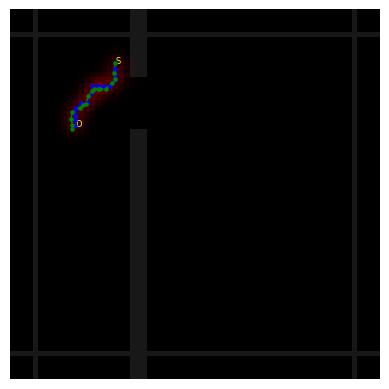

final_position: (15, 11)
action position: [15.27480914 10.93911893]


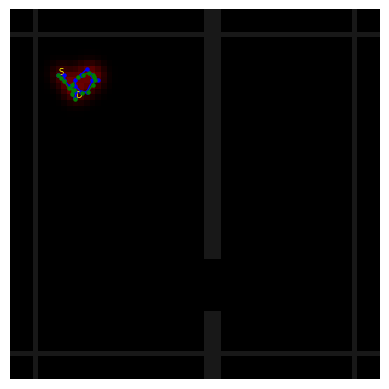

final_position: (60, 37)
action position: [69.59796205 37.45270539]


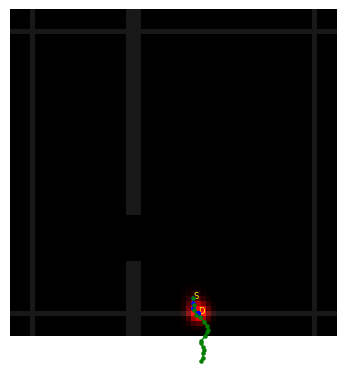

In [296]:
N = states.shape[0]
random_data_points = random.sample(range(N), 5)
for i in random_data_points:
    visualize_data_point(i, False, 4)